In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import shutil
from pathlib import Path

import jax.random as jr
import jax.numpy as jnp
from omegaconf import OmegaConf
import matplotlib.pyplot as plt

from cohlib.utils import pickle_open
from cohlib.jax.dists import sample_from_gamma
from cohlib.jax.observations import add0



In [3]:
from cohlib.utils import pickle_save, gamma_root, pickle_open
# from cohlib.jax.gamma_create import k2_full
from cohlib.jax.dists import cif_alpha_relu, sample_spikes_from_lams

In [4]:
def plot_data(gamma_true_full, lseed, oseed, alpha, L, k=0):

    lrk = jr.key(lseed)
    zs = sample_from_gamma(lrk, gamma_true_full, L)

    zs_0dc = jnp.apply_along_axis(add0, 0, zs)
    xs = jnp.fft.irfft(zs_0dc, axis=0)

    ork = jr.key(oseed)

    obs = sample_spikes(ork, xs, alpha)

    fig, ax = plt.subplots(2,1,figsize=(5,3))
    for l in range(3):
        ax[0].plot(xs[:,k,l])
        ax[1].plot(obs[:,k,l])
    plt.tight_layout()


In [5]:
def k2_full_multitarget1(flow, fhigh, scalep_target, scalep_offtarget):
    N = 500
    K = 2
    nonzero_freqs = jnp.arange(flow,fhigh+1)
    Nnz = nonzero_freqs.size

    scale_target = 10**scalep_target
    scale_offtarget = 10**scalep_offtarget

    target_freqs = jnp.array([1, 13, 28])
    mt_scales = [0.5, 1, 0.8]
    target_inds = jnp.where(jnp.isin(nonzero_freqs, target_freqs))[0]

    gamma_target = jnp.array([[5,1],[1,5]],dtype=complex) + jnp.array([[0,-1],[1,0]],dtype=complex)*1j

    gamma_nonzero = jnp.stack([jnp.eye(K, dtype=complex) for _ in range(Nnz)])*scale_offtarget

    # diag_mask = jnp.stack([jnp.eye(K) for n in range(Nnz)])
    # rk = jr.key(seed)
    # gamma_nonzero = gamma_nonzero + jr.normal(rk, gamma_nonzero.shape)*diag_mask*0.01*scale
    for i, j in enumerate(target_freqs):
        mt_scale = mt_scales[i]
        gamma_nonzero = gamma_nonzero.at[j,:,:].set(gamma_target*scale_target*mt_scale)

    gamma_full = jnp.zeros((N,K,K), dtype=complex)
    freqs = jnp.arange(1,N+1)
    nonzero_inds = jnp.where(jnp.isin(freqs, nonzero_freqs))[0]

    gamma_full = gamma_full.at[nonzero_inds,:,:].set(gamma_nonzero)

    save_path = os.path.join(gamma_root(), f'k2-full{flow}-{fhigh}-10-28-{scalep_target}-{scalep_offtarget}.pickle')
    save_dict = {'gamma': gamma_full, 'freqs': freqs, 'nonzero_inds': nonzero_inds, 'target_inds': target_inds}

    return gamma_full, nonzero_inds, target_freqs

    # pickle_save(save_dict, save_path)

In [6]:
gamma_full, nz_model, nz_target = k2_full_multitarget1(1, 50, 5, 1)

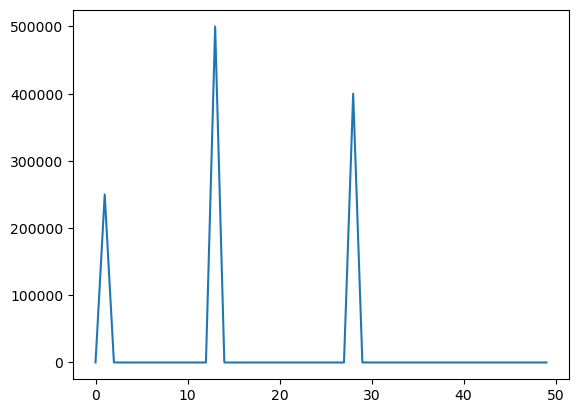

In [7]:
k = 0
plt.plot(gamma_full[nz_model,k,k].real)

In [8]:
def pow(gamma, k, db=False, freq_inds=None):
    if freq_inds is None:
        freq_inds = jnp.arange(gamma.shape[0])
    S = gamma[freq_inds,k,k].real
    if db is True:
        S = 10*jnp.log10(S+1e-15)
    return S


### Load Gamma and Jax Results

In [9]:
from cohlib.utils import gamma_root
# gamma_name = 'k2-single-10'
flow=1
fhigh=50
spt=5
spot=1
gamma_path = os.path.join(gamma_root(), f"k2-full{flow}-{fhigh}-10-{spt}-{spot}.pickle")
gamma_load = pickle_open(gamma_path)
# gamma_full = gamma_load['gamma']
# freqs = gamma_load['freqs']
# nz = gamma_load['nonzero_inds']
nz = nz_model

scale = 1e4

gamma_full = gamma_full*scale

# nz_target = jnp.array([9])
K = gamma_full.shape[-1]

L = 500
lseed = 7
lrk = jr.key(lseed)

zs = sample_from_gamma(lrk, gamma_full, L)
zs_0dc = jnp.apply_along_axis(add0, 0, zs)
xs = jnp.fft.irfft(zs_0dc, axis=0)


In [10]:
def sample_spikes(rk, xs, alpha, C=1, delta=1e-3):
    K = xs.shape[1]
    alphas = jnp.ones(K)*alpha
    lams_single = cif_alpha_relu(alphas, xs)
    lams = jnp.stack([lams_single for _ in range(C)], axis=1)
    samples = jr.poisson(rk, lams*delta)
    return lams.squeeze(), samples.squeeze()

alpha = 200
oseed = 7
ork = jr.key(oseed) 
lams, samples_pre = sample_spikes(ork, xs, alpha)
samples = samples_pre
samples_thresh = samples_pre.at[samples_pre > 1].set(1)

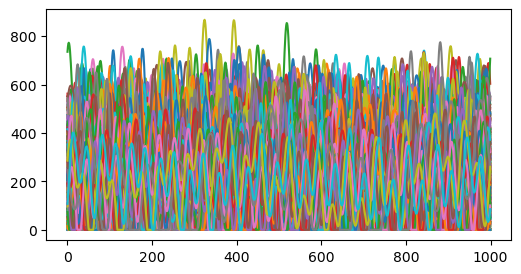

In [11]:
delta = 1e-3
k = 0
l = 0
fig, ax = plt.subplots(figsize=(6,3))

for l in range(L):
    ax.plot(lams[:,k,l])

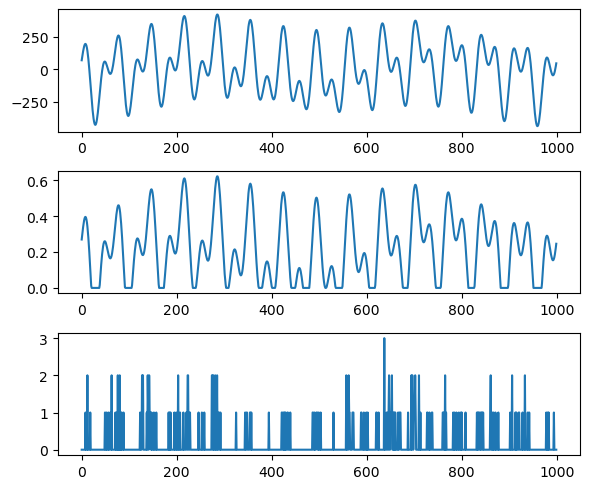

In [12]:
delta = 1e-3
k = 0
l = 0
fig, ax = plt.subplots(3,1, figsize=(6,5))

ax[0].plot(xs[:,k,l])
ax[1].plot(lams[:,k,l]*delta)
ax[2].plot(samples[:,k,l])

plt.tight_layout()

In [13]:
def naive_estimator(spikes, nonzero_inds=None):
    "spikes has shape (time, unit, trial)"
    n_f0 = jnp.fft.rfft(spikes, axis=0)
    n_f = n_f0[1:,:,:]
    naive_est = jnp.einsum('jkl,jil->jkil', n_f, n_f.conj()).mean(-1)

    if nonzero_inds is None:
        return naive_est
    else:
        return naive_est[nonzero_inds, :, :]


In [14]:
naive_est = naive_estimator(samples, nz)
naive_est_thresh = naive_estimator(samples_thresh, nz)

In [15]:
gamma_full[9]*1e-3

Array([[100.00001+0.j,   0.     +0.j],
       [  0.     +0.j, 100.00001+0.j]], dtype=complex64)

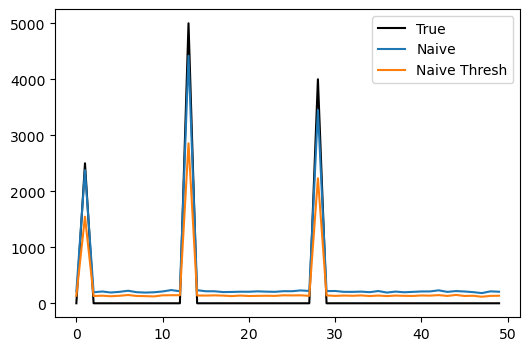

In [16]:
k = 0
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(gamma_full[nz,k,k].real * 1e-6, color='k', label='True')
ax.plot(naive_est[:,k,k].real, label='Naive')
ax.plot(naive_est_thresh[:,k,k].real, label='Naive Thresh')
ax.legend()

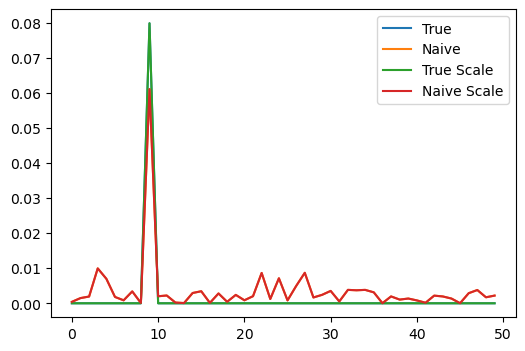

In [35]:
from cohlib.mvcn import thr_coherence
fig, ax = plt.subplots(figsize=(6,4))
true_coh = thr_coherence(gamma_full[nz,:,:])
true_coh_scale = thr_coherence(gamma_full[nz,:,:] * 1e-6)
naive_coh = thr_coherence(naive_est)
naive_coh_scale = thr_coherence(naive_est * 1e6)
ax.plot(true_coh, label='True')
ax.plot(naive_coh, label='Naive')
ax.plot(true_coh_scale, label='True Scale')
ax.plot(naive_coh_scale, label='Naive Scale')
ax.legend()

#### Perfect
Next.. 
- copy workflow from previously for Gaussian obs
- implement jax pp with relu
- compare behavior to naive / old
- see if we can replicate jax behavior by modifying old like w/ gaussian obs

### Let's work out cost function here

In [62]:
def _obs_cost_gaussian(z, data, K, N, nonzero_inds, params, zs_flattened):
    obs_var = params['obs_var']
    if zs_flattened:
        z = z.reshape(-1,K)
    zs = jnp.zeros((N,K), dtype=complex)
    zs = zs.at[nonzero_inds,:].set(z)

    zs_0dc = jnp.apply_along_axis(add0, 0, zs)
    xs = jnp.fft.irfft(zs_0dc, axis=0)
    err = (data - xs)

    # partial_ll = -0.5 * (err**2 * 1/obs_var).sum()
    a = -0.5 * (err**2 * 1/obs_var)
    b = a.sum(0)
    partial_ll = b.sum()
    
    obs_cost = -partial_ll

    return obs_cost

def _obs_cost_pp_relu(z, data, K, N, nonzero_inds, params, zs_flattened):
    alpha = params['alpha']
    delta = params['delta']
    if zs_flattened:
        z = z.reshape(-1,K)
    zs = jnp.zeros((N,K), dtype=complex)
    zs = zs.at[nonzero_inds,:].set(z)

    zs_0dc = jnp.apply_along_axis(add0, 0, zs)
    xs = jnp.fft.irfft(zs_0dc, axis=0)

    if jnp.ndim(alpha) == 0:
        lams = xs + alpha
    else:
        xs + alphas[None,:,None]

    lams = lams.at[lams < 0].set(jnp.nan)
    log_lams = jnp.nan_to_num(jnp.log(lams), nan=0, neginf=0, posinf=0)
    partial_ll_calc = obs*(jnp.log(delta) + log_lams) - jnp.nan_to_num(lams)*delta
    partial_ll = partial_ll_calc.sum()
    obs_cost = -partial_ll

    return obs_cost
     


In [63]:
alphas = jnp.array([alpha, alpha])
xs + alphas[None,:,None]

Array([[[-1955.2649  , -1043.8306  ,   649.2239  , ...,   946.23236 ,
         -2762.9175  ,    13.806015],
        [ 3395.294   ,   277.37823 ,  -834.0056  , ...,  1779.2278  ,
         -5265.9766  ,  -264.0864  ]],

       [[-1794.8712  ,  -927.72705 ,   614.25244 , ...,   945.3147  ,
         -2567.7373  ,  -211.34363 ],
        [ 3339.631   ,   178.61093 ,  -887.8762  , ...,  1721.8597  ,
         -5139.0386  ,  -227.52786 ]],

       [[-1631.1791  ,  -798.9964  ,   577.69214 , ...,   937.5496  ,
         -2371.0825  ,  -431.10956 ],
        [ 3273.4004  ,    83.63372 ,  -937.28296 , ...,  1655.9823  ,
         -4988.0186  ,  -195.53159 ]],

       ...,

       [[-2409.9592  , -1307.26    ,   755.1646  , ...,   906.9971  ,
         -3319.7952  ,   711.9459  ],
        [ 3484.566   ,   587.72107 ,  -637.494   , ...,  1881.6199  ,
         -5492.4463  ,  -409.39557 ]],

       [[-2263.794   , -1233.7144  ,   718.74316 , ...,   926.7384  ,
         -3141.227   ,   476.679   ],
       

In [64]:
obs = samples.copy()
delta = 1e-3
alpha = 5


lams = xs + alpha
lams = lams.at[lams < 0].set(jnp.nan)
log_lams = jnp.nan_to_num(jnp.log(lams), nan=0, neginf=0, posinf=0)
cost_calc = obs*(jnp.log(delta) + log_lams) - jnp.nan_to_num(lams)*delta
cost = cost_calc.sum()

In [65]:
len(jnp.shape(alpha))

0

In [66]:
lams = xs + alpha
lams = lams.at[lams < 0].set(jnp.nan)
lams

Array([[[       nan,        nan,  454.22388, ...,  751.23236,
                nan,        nan],
        [3200.294  ,   82.37823,        nan, ..., 1584.2278 ,
                nan,        nan]],

       [[       nan,        nan,  419.25247, ...,  750.3147 ,
                nan,        nan],
        [3144.631  ,        nan,        nan, ..., 1526.8597 ,
                nan,        nan]],

       [[       nan,        nan,  382.69214, ...,  742.5496 ,
                nan,        nan],
        [3078.4004 ,        nan,        nan, ..., 1460.9823 ,
                nan,        nan]],

       ...,

       [[       nan,        nan,  560.1646 , ...,  711.9971 ,
                nan,  516.9459 ],
        [3289.566  ,  392.7211 ,        nan, ..., 1686.6199 ,
                nan,        nan]],

       [[       nan,        nan,  523.74316, ...,  731.7384 ,
                nan,  281.679  ],
        [3274.1658 ,  288.0601 ,        nan, ..., 1665.5837 ,
                nan,        nan]],

       [[       n

In [67]:
lams = xs + alpha
lams = jnp.where(lams < 0, jnp.nan, lams)
lams

Array([[[       nan,        nan,  454.22388, ...,  751.23236,
                nan,        nan],
        [3200.294  ,   82.37823,        nan, ..., 1584.2278 ,
                nan,        nan]],

       [[       nan,        nan,  419.25247, ...,  750.3147 ,
                nan,        nan],
        [3144.631  ,        nan,        nan, ..., 1526.8597 ,
                nan,        nan]],

       [[       nan,        nan,  382.69214, ...,  742.5496 ,
                nan,        nan],
        [3078.4004 ,        nan,        nan, ..., 1460.9823 ,
                nan,        nan]],

       ...,

       [[       nan,        nan,  560.1646 , ...,  711.9971 ,
                nan,  516.9459 ],
        [3289.566  ,  392.7211 ,        nan, ..., 1686.6199 ,
                nan,        nan]],

       [[       nan,        nan,  523.74316, ...,  731.7384 ,
                nan,  281.679  ],
        [3274.1658 ,  288.0601 ,        nan, ..., 1665.5837 ,
                nan,        nan]],

       [[       n

In [68]:
jnp.ndim(alpha)

0